In [1]:
import polars as pl
import numpy as np
import os, re, math
import matplotlib.pyplot as plt
import seaborn as sns
import dataclasses

In [2]:
@dataclasses.dataclass
class NucleotideID:
    pdbid: str
    chain: str
    base: str
    id: int
    ins: str
    alt: str
def read_id_list(file) -> pl.DataFrame:
    results = []
    with open(file) as f:
        for l in f:
            m = re.match(r"^(?P<pdbid>[a-zA-Z0-9]{4})_(?P<chain>[a-zA-Z0-9]+)_(?P<base>[a-zA-Z0-9]+)(\.(?P<alt>[a-zA-Z0-9]+))?_(?P<id>-?\d+)(\.(?P<ins>[a-zA-Z0-9]+))?$", l)
            if m is None:
                raise Exception(f"Could not parse id: {l}")
            results.append(NucleotideID(
                pdbid=m.group("pdbid"),
                chain=m.group("chain"),
                base=m.group("base"),
                id=int(m.group("id")),
                ins=m.group("ins") or ' ',
                alt=m.group("alt") or '?',
            ))
    return pl.DataFrame(results)

residue_list = {
    "RNA-1.8-3.5": read_id_list("/home/exyi/tmp/basepaircsv/hbonds/non_redundant_RNA_filtered_residues_1.8-3.5A.csv").with_columns(pl.lit(True).alias("rna_lres")),
    "RNA-0-1.8": read_id_list("/home/exyi/tmp/basepaircsv/hbonds/non_redundant_RNA_filtered_residues_0-1.8A.csv").with_columns(pl.lit(True).alias("rna_hres")),
    "DNA-1.8-3.5": read_id_list("/home/exyi/tmp/basepaircsv/hbonds/non_redundant_DNA_filtered_residues_1.8-3.5A.csv").with_columns(pl.lit(True).alias("dna_lres")),
    "DNA-0-1.8": read_id_list("/home/exyi/tmp/basepaircsv/hbonds/non_redundant_DNA_filtered_residues_0-1.8A.csv").with_columns(pl.lit(True).alias("dna_hres")),
}
residue_list["DNA-0-1.8"][["pdbid", "chain", "base", "id", "ins", "alt"]]

pdbid,chain,base,id,ins,alt
str,str,str,i64,str,str
"""1a2e""","""B""","""DA""",12,""" ""","""?"""
"""1a2e""","""B""","""DA""",14,""" ""","""?"""
"""1a2e""","""B""","""DA""",18,""" ""","""?"""
"""1a2e""","""B""","""DG""",11,""" ""","""?"""
"""1a2e""","""B""","""DG""",13,""" ""","""?"""
"""1a2e""","""B""","""DG""",19,""" ""","""?"""
"""1bf4""","""C""","""DA""",112,""" ""","""?"""
"""1bf4""","""C""","""DA""",113,""" ""","""?"""
"""1bf4""","""C""","""DC""",110,""" ""","""?"""


In [101]:
def load_pair_table(file: str):
    df = pl.read_parquet(file) if file.endswith(".parquet") else pl.read_csv(file)

    df = df.with_columns(
        pl.col("hb_0_heavy_a_angle") / np.pi * 180,
        pl.col("hb_1_heavy_a_angle") / np.pi * 180,
        pl.col("hb_2_heavy_a_angle") / np.pi * 180
    )

    rcols = { f"{name}-r{resix}":
        df.join(reslist.with_columns(pl.lit(True).alias("__tmp")), left_on=["pdbid", f"chain{resix}", f"res{resix}", f"nr{resix}", f"alt{resix}", f"ins{resix}"], right_on=["pdbid", "chain", "base", "id", "alt", "ins"], how="left")
            .get_column("__tmp")
            .fill_null(False)
        for name, reslist in residue_list.items()
        for resix in [1, 2]
    }
    df = df.with_columns(**rcols)
    df = df.with_columns(**{
        name: df[f"{name}-r1"] | df[f"{name}-r2"]
        for name in residue_list.keys()
    })
    df = df.with_columns(
        pl.when(pl.col("RNA-0-1.8")).then(pl.lit("RNA H"))
        .when(pl.col("DNA-0-1.8")).then(pl.lit("DNA H"))
        .when(pl.col("RNA-1.8-3.5")).then(pl.lit("RNA L"))
        .when(pl.col("DNA-1.8-3.5")).then(pl.lit("DNA L"))
        .when(pl.col("res1").str.starts_with("D")).then(pl.lit("DNA"))
        .otherwise(pl.lit("RNA"))
        .alias("label")
    )
    return df

load_pair_table("/home/exyi/tmp/basepaircsv/cWW-CG-nodssr.csv")#.filter(pl.col("RNA-1.8-3.5"))

pdbid,model,chain1,res1,nr1,ins1,atom1,alt1,chain2,res2,nr2,ins2,atom2,alt2,image,dist,rmsd,tx,ty,tz,r11,r12,r13,r21,r22,r23,r31,r32,r33,t1MMB,t2MMB,t3MMB,theta,axMMB,ayMMB,azMMB,hb_0_length,hb_0_heavy_a_angle,hb_1_length,hb_1_heavy_a_angle,hb_2_length,hb_2_heavy_a_angle,bogopropeller,deposition_date,structure_method,resolution,RNA-1.8-3.5-r1,RNA-1.8-3.5-r2,RNA-0-1.8-r1,RNA-0-1.8-r2,DNA-1.8-3.5-r1,DNA-1.8-3.5-r2,DNA-0-1.8-r1,DNA-0-1.8-r2,RNA-1.8-3.5,RNA-0-1.8,DNA-1.8-3.5,DNA-0-1.8,label
str,i64,str,str,i64,str,str,str,str,str,i64,str,str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,f64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,str
"""116d""",1,"""A""","""DC""",1,""" ""","""O2""","""?""","""A""","""DG""",12,""" ""","""N2""","""?""",10,2.879,0.114,-5.397325,7.221576,-0.700056,0.320896,0.946476,0.034777,0.931423,-0.322023,0.169566,0.171689,-0.022021,-0.984905,-0.539732,0.722158,-0.070006,3.023337,-0.811947,-0.580234,-0.063794,null,null,null,null,null,null,null,"""1993-02-10""","""X-RAY DIFFRACT…",2.5,false,false,false,false,true,true,false,false,false,false,true,false,"""DNA L"""
"""116d""",1,"""A""","""DC""",2,""" ""","""O2""","""?""","""A""","""DG""",11,""" ""","""N2""","""?""",10,2.829,0.105,-5.382149,7.200491,-0.29298,0.291137,0.956208,0.030098,0.953904,-0.292544,0.066967,0.072839,0.009214,-0.997301,-0.538215,0.720049,-0.029298,3.105643,-0.803402,-0.594575,-0.032042,null,null,null,null,null,null,null,"""1993-02-10""","""X-RAY DIFFRACT…",2.5,false,false,false,false,true,true,false,false,false,false,true,false,"""DNA L"""
"""116d""",1,"""A""","""DC""",6,""" ""","""N4""","""?""","""A""","""DG""",7,""" ""","""O6""","""?""",10,2.789,0.104,-5.095463,7.258094,1.117033,0.368293,0.899632,0.234568,0.916036,-0.394249,0.073791,0.158863,0.187697,-0.969295,-0.509546,0.725809,0.111703,3.210522,0.826905,0.549588,0.119089,null,null,null,null,null,null,null,"""1993-02-10""","""X-RAY DIFFRACT…",2.5,false,false,false,false,true,true,false,false,false,false,true,false,"""DNA L"""
"""116d""",1,"""A""","""DC""",10,""" ""","""N4""","""?""","""A""","""DG""",3,""" ""","""O6""","""?""",10,2.832,0.116,-5.091605,7.44573,-0.23436,0.35052,0.924625,0.149011,0.928416,-0.363978,0.07459,0.123204,0.112199,-0.986018,-0.509161,0.744573,-0.023436,3.16448,0.821716,0.563845,0.08283,null,null,null,null,null,null,null,"""1993-02-10""","""X-RAY DIFFRACT…",2.5,false,false,false,false,true,true,false,false,false,false,true,false,"""DNA L"""
"""117d""",1,"""A""","""DC""",2,""" ""","""N4""","""?""","""A""","""DG""",11,""" ""","""O6""","""?""",10,2.831,0.109,-5.321233,7.218376,-0.858439,0.282482,0.957936,0.050615,0.940176,-0.286948,0.183657,0.190456,-0.004293,-0.981686,-0.532123,0.721838,-0.085844,3.023851,-0.799997,-0.595223,-0.075596,null,null,null,null,null,null,null,"""1993-02-10""","""X-RAY DIFFRACT…",2.55,false,false,false,false,true,true,false,false,false,false,true,false,"""DNA L"""
"""117d""",1,"""A""","""DC""",6,""" ""","""O2""","""?""","""A""","""DG""",7,""" ""","""N2""","""?""",10,2.838,0.102,-4.641924,7.542647,1.107318,0.399261,0.873175,0.279566,0.906199,-0.422151,0.024329,0.139263,0.243629,-0.959818,-0.464192,0.754265,0.110732,3.273185,0.835659,0.534638,0.125843,null,null,null,null,null,null,null,"""1993-02-10""","""X-RAY DIFFRACT…",2.55,false,false,false,false,true,true,false,false,false,false,true,false,"""DNA L"""
"""117d""",1,"""A""","""DC""",10,""" ""","""O2""","""?""","""A""","""DG""",3,""" ""","""N2""","""?""",10,2.754,0.114,-5.003486,7.445379,-0.163717,0.36876,0.921002,0.125584,0.918748,-0.381656,0.101195,0.14113,0.078063,-0.986909,-0.500349,0.744538,-0.016372,3.127611,-0.827263,-0.556002,-0.080605,null,null,null,null,null,null,null,"""1993-02-10""","""X-RAY DIFFRACT…",2.55,false,false,false,false,true,true,false,false,false,false,true,false,"""DNA L"""
"""117d""",1,"""A""","""DC""",12,""" ""","""O2""","""?""","""A""","""DG""",1,""" ""","""N2""","""?"""

In [8]:
%config InlineBackend.figure_formats = ['png']
plt.rcParams["figure.figsize"] = (10, 6)
def show():
    os.makedirs("plots", exist_ok=True)
    plt.savefig("plots/" + plt.gcf().axes[0].get_title() + ".pdf")
    plt.show()


In [104]:
data = load_pair_table("/home/exyi/tmp/basepaircsv/cWW-CG-dssr2.csv.parquet")

is_high_quality = pl.col("RNA-0-1.8") | pl.col("DNA-0-1.8")
is_some_quality = pl.col("RNA-0-1.8") | pl.col("DNA-0-1.8") | pl.col("DNA-1.8-3.5") | pl.col("RNA-1.8-3.5")
is_med_quality = pl.col("RNA-1.8-3.5") | pl.col("DNA-1.8-3.5")
is_dna = pl.col("res1").str.starts_with("D") | pl.col("res2").str.starts_with("D")
is_rna = pl.col("res1").str.starts_with("D").is_not() | pl.col("res2").str.starts_with("D").is_not()

print(data.schema)
data.sum()

{'pdbid': Utf8, 'model': Int64, 'chain1': Utf8, 'res1': Utf8, 'nr1': Int64, 'ins1': Utf8, 'atom1': Utf8, 'alt1': Utf8, 'chain2': Utf8, 'res2': Utf8, 'nr2': Int64, 'ins2': Utf8, 'atom2': Utf8, 'alt2': Utf8, 'image': Int64, 'dist': Float64, 'rmsd': Float64, 'tx': Float64, 'ty': Float64, 'tz': Float64, 'r11': Float64, 'r12': Float64, 'r13': Float64, 'r21': Float64, 'r22': Float64, 'r23': Float64, 'r31': Float64, 'r32': Float64, 'r33': Float64, 't1MMB': Float64, 't2MMB': Float64, 't3MMB': Float64, 'theta': Float64, 'axMMB': Float64, 'ayMMB': Float64, 'azMMB': Float64, 'hb_0_length': Float64, 'hb_0_heavy_a_angle': Float64, 'hb_1_length': Float64, 'hb_1_heavy_a_angle': Float64, 'hb_2_length': Float64, 'hb_2_heavy_a_angle': Float64, 'bogopropeller': Float64, 'deposition_date': Utf8, 'structure_method': Utf8, 'resolution': Float32, 'dssr_pairing_type': Utf8, 'dssr_shear': Float64, 'dssr_stretch': Float64, 'dssr_stagger': Float64, 'dssr_buckle': Float64, 'dssr_propeller': Float64, 'dssr_opening

pdbid,model,chain1,res1,nr1,ins1,atom1,alt1,chain2,res2,nr2,ins2,atom2,alt2,image,dist,rmsd,tx,ty,tz,r11,r12,r13,r21,r22,r23,r31,r32,r33,t1MMB,t2MMB,t3MMB,theta,axMMB,ayMMB,azMMB,hb_0_length,hb_0_heavy_a_angle,hb_1_length,hb_1_heavy_a_angle,hb_2_length,hb_2_heavy_a_angle,bogopropeller,deposition_date,structure_method,resolution,dssr_pairing_type,dssr_shear,dssr_stretch,dssr_stagger,dssr_buckle,dssr_propeller,dssr_opening,dssr_shift,dssr_slide,dssr_rise,dssr_tilt,dssr_roll,dssr_twist,RNA-1.8-3.5-r1,RNA-1.8-3.5-r2,RNA-0-1.8-r1,RNA-0-1.8-r2,DNA-1.8-3.5-r1,DNA-1.8-3.5-r2,DNA-0-1.8-r1,DNA-0-1.8-r2,RNA-1.8-3.5,RNA-0-1.8,DNA-1.8-3.5,DNA-0-1.8,label
str,i64,str,str,i64,str,str,str,str,str,i64,str,str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f32,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,str
null,68661,null,null,45772391,null,null,null,null,null,45933152,null,null,null,3305,189333.24,6709.512,-351394.456075,493443.409726,33436.21142,21917.915263,62849.015733,9851.056844,63788.37077,-22253.103519,2647.428477,5838.8742,8423.942934,-66007.771908,-35139.445608,49344.340973,3343.621142,217669.784004,14615.288838,10102.870096,2172.206764,197435.578713,7.8040e6,193465.077339,7.7418e6,185863.115293,8.1708e6,0.0,null,null,186387.328125,null,-182.4236,-8206.0565,-3728.395,6173.8248,-559033.0496,62096.6827,-5272.9765,-91557.61,193709.227,-17081.0302,335783.1433,2.2233e6,35155,33751,690,773,6455,6383,1120,1136,41494,1047,12546,2116,null


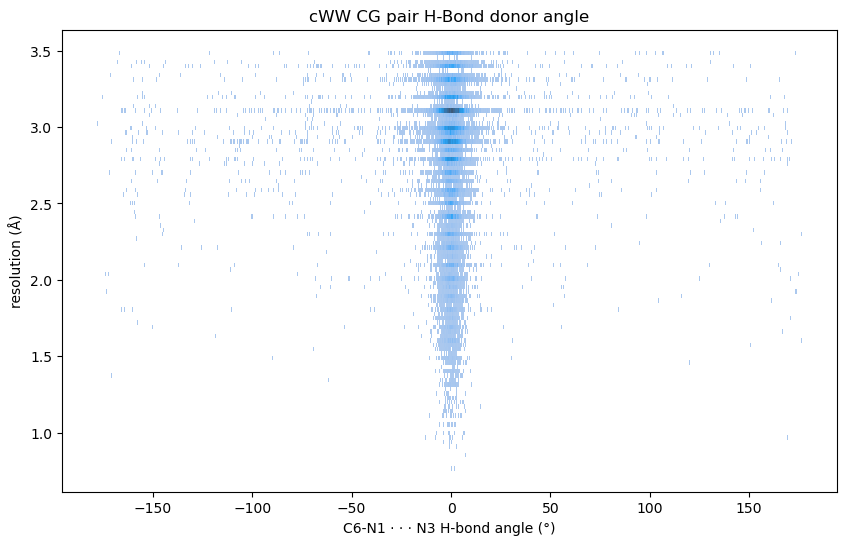

In [111]:
sns.histplot(data.filter(is_some_quality), x="dssr_tilt", y="resolution").set(title="cWW CG pair H-Bond donor angle", xlabel="C6-N1 · · · N3 H-bond angle (°)", ylabel="resolution (Å)")
show()

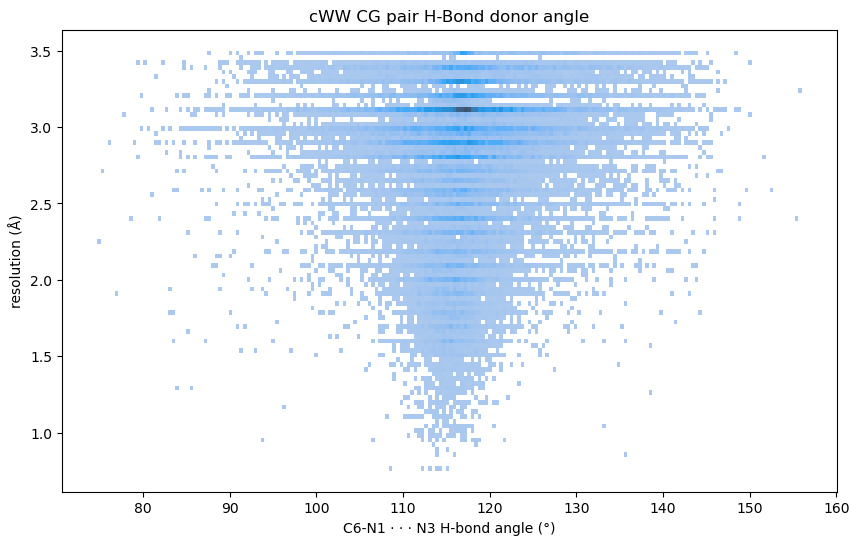

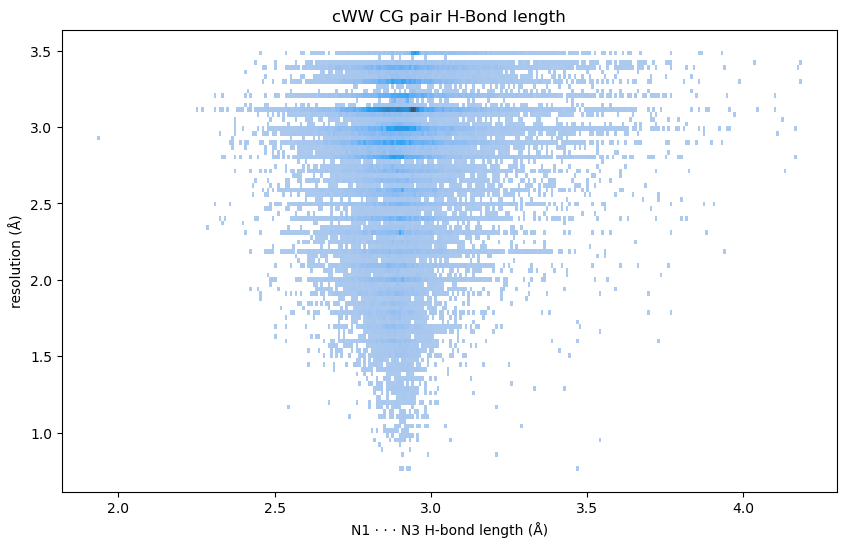

In [99]:
dd = data.filter(is_some_quality)

sns.histplot(data.filter(is_some_quality), x="hb_1_heavy_a_angle", y="resolution").set(title="cWW CG pair H-Bond donor angle", xlabel="C6-N1 · · · N3 H-bond angle (°)", ylabel="resolution (Å)")
show()
sns.histplot(data.filter(is_some_quality), x="hb_1_length", y="resolution").set(title="cWW CG pair H-Bond length", xlabel="N1 · · · N3 H-bond length (Å)", ylabel="resolution (Å)")
show()

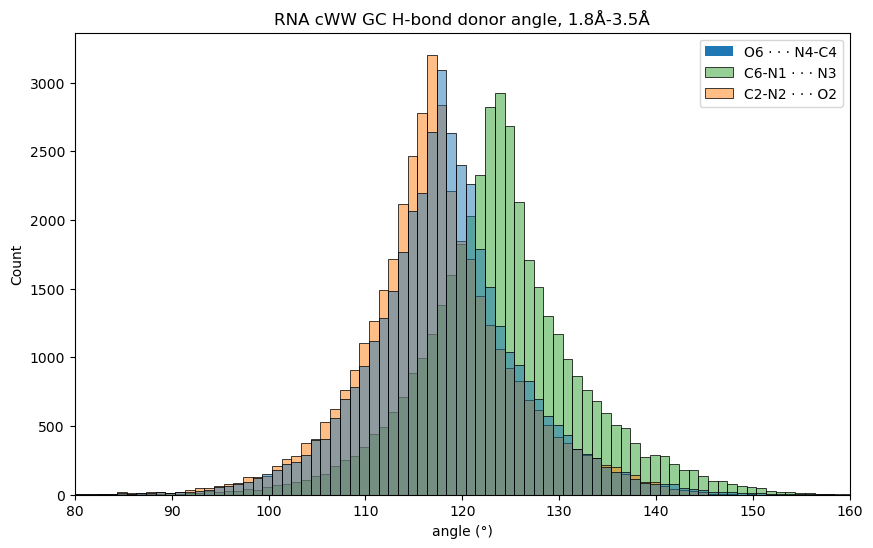

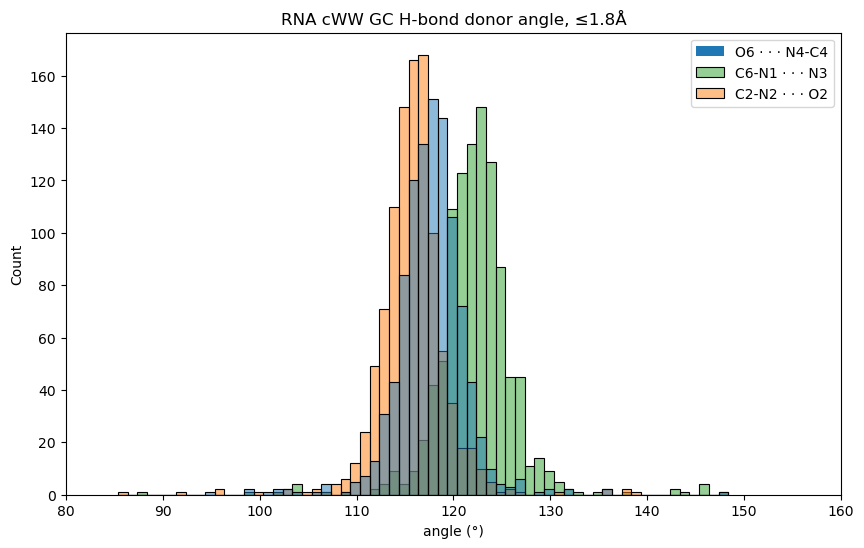

In [84]:
sns.histplot(data=data.filter(is_med_quality & is_rna)[["hb_0_heavy_a_angle", "hb_1_heavy_a_angle", "hb_2_heavy_a_angle"]], binwidth=1).set(xlabel="angle (°)", title="RNA cWW GC H-bond donor angle, 1.8Å-3.5Å")
plt.legend(["O6 · · · N4-C4", "C6-N1 · · · N3", "C2-N2 · · · O2"])
plt.xlim(80, 160)
show()
sns.histplot(data=data.filter(is_high_quality & is_rna)[["hb_0_heavy_a_angle", "hb_1_heavy_a_angle", "hb_2_heavy_a_angle"]], binwidth=1).set(xlabel="angle (°)", title="RNA cWW GC H-bond donor angle, ≤1.8Å")
plt.legend(["O6 · · · N4-C4", "C6-N1 · · · N3", "C2-N2 · · · O2"])
plt.xlim(80, 160)
show()

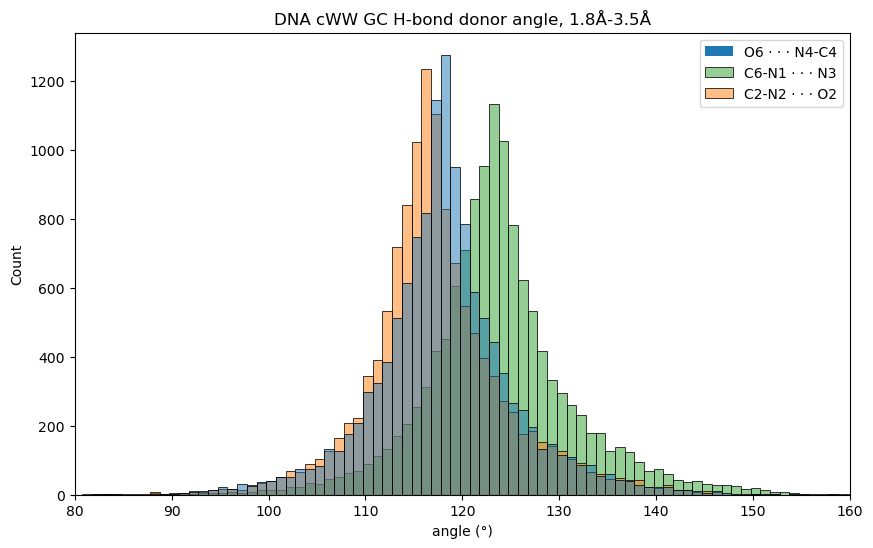

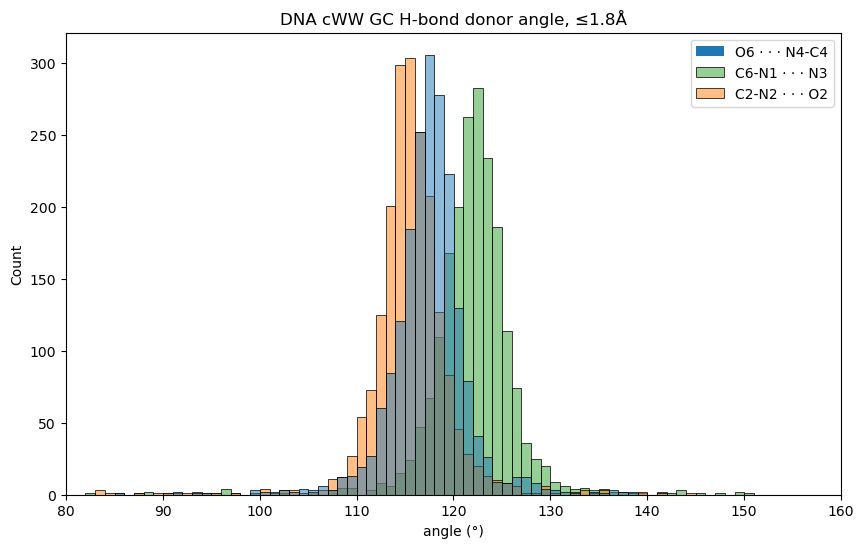

In [83]:
sns.histplot(data=data.filter(is_med_quality & is_dna)[["hb_0_heavy_a_angle", "hb_1_heavy_a_angle", "hb_2_heavy_a_angle"]], binwidth=1).set(xlabel="angle (°)", title="DNA cWW GC H-bond donor angle, 1.8Å-3.5Å")
plt.legend(["O6 · · · N4-C4", "C6-N1 · · · N3", "C2-N2 · · · O2"])
plt.xlim(80, 160)
show()
sns.histplot(data=data.filter(is_high_quality & is_dna)[["hb_0_heavy_a_angle", "hb_1_heavy_a_angle", "hb_2_heavy_a_angle"]], binwidth=1).set(xlabel="angle (°)", title="DNA cWW GC H-bond donor angle, ≤1.8Å")
plt.legend(["O6 · · · N4-C4", "C6-N1 · · · N3", "C2-N2 · · · O2"])
plt.xlim(80, 160)
show()

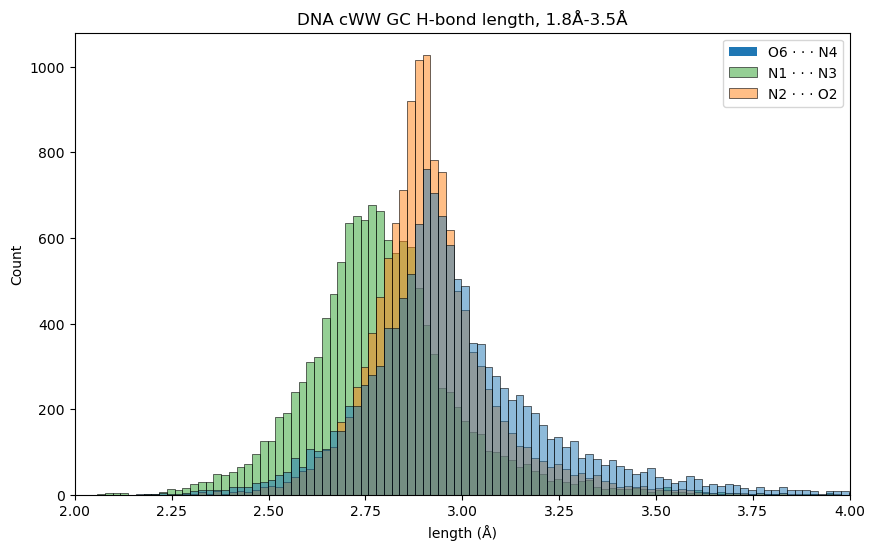

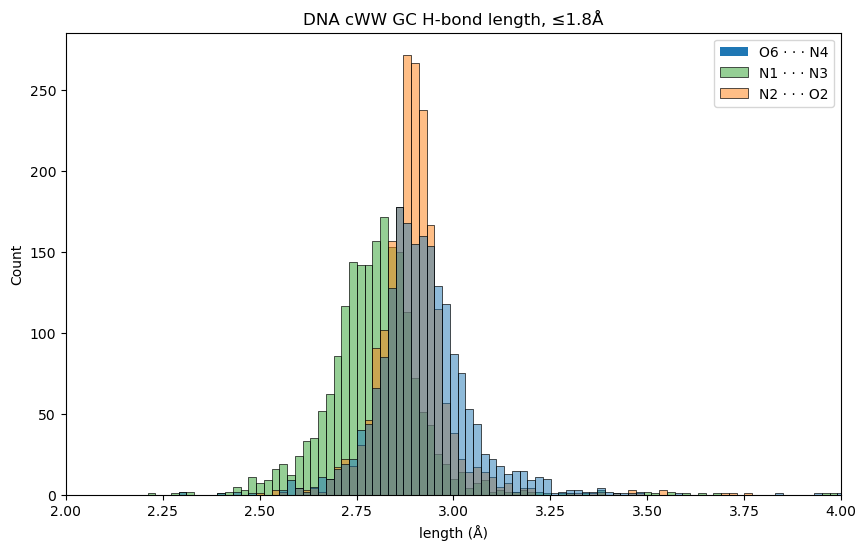

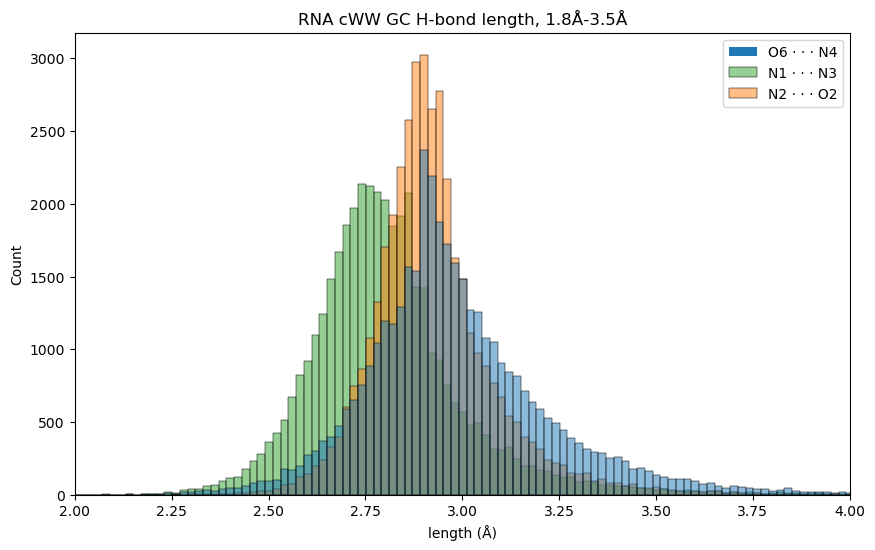

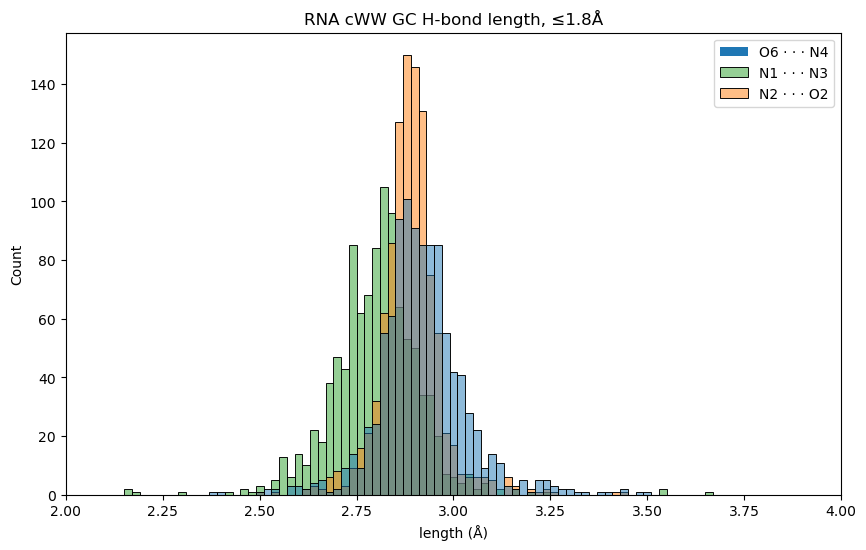

In [82]:
sns.histplot(data=data.filter(is_med_quality & is_dna)[["hb_0_length", "hb_1_length", "hb_2_length"]], binwidth=0.02).set(xlabel="length (Å)", title="DNA cWW GC H-bond length, 1.8Å-3.5Å")
plt.legend(["O6 · · · N4", "N1 · · · N3", "N2 · · · O2"])
plt.xlim(2, 4)
show()
sns.histplot(data=data.filter(is_high_quality & is_dna)[["hb_0_length", "hb_1_length", "hb_2_length"]], binwidth=0.02).set(xlabel="length (Å)", title="DNA cWW GC H-bond length, ≤1.8Å")
plt.legend(["O6 · · · N4", "N1 · · · N3", "N2 · · · O2"])
plt.xlim(2, 4)
show()
sns.histplot(data=data.filter(is_med_quality & is_rna)[["hb_0_length", "hb_1_length", "hb_2_length"]], binwidth=0.02).set(xlabel="length (Å)", title="RNA cWW GC H-bond length, 1.8Å-3.5Å")
plt.legend(["O6 · · · N4", "N1 · · · N3", "N2 · · · O2"])
plt.xlim(2, 4)
show()
sns.histplot(data=data.filter(is_high_quality & is_rna)[["hb_0_length", "hb_1_length", "hb_2_length"]], binwidth=0.02).set(xlabel="length (Å)", title="RNA cWW GC H-bond length, ≤1.8Å")
plt.legend(["O6 · · · N4", "N1 · · · N3", "N2 · · · O2"])
plt.xlim(2, 4)
show()

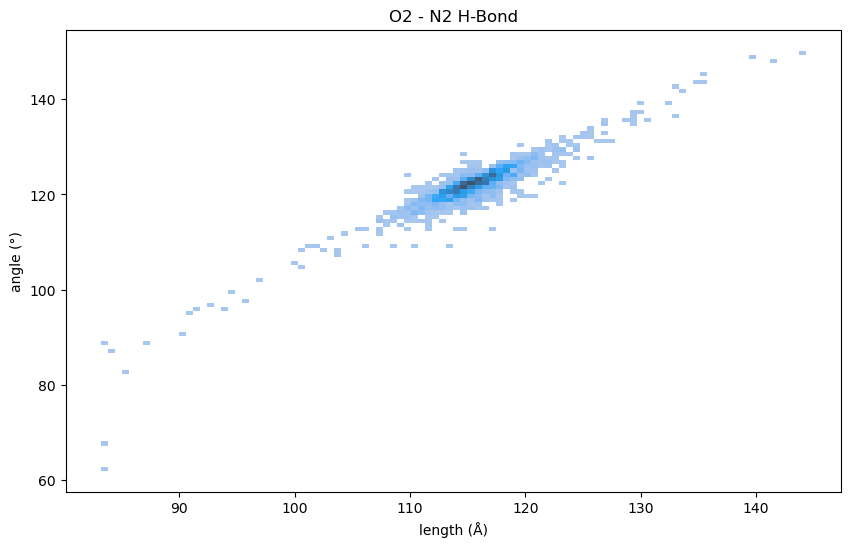

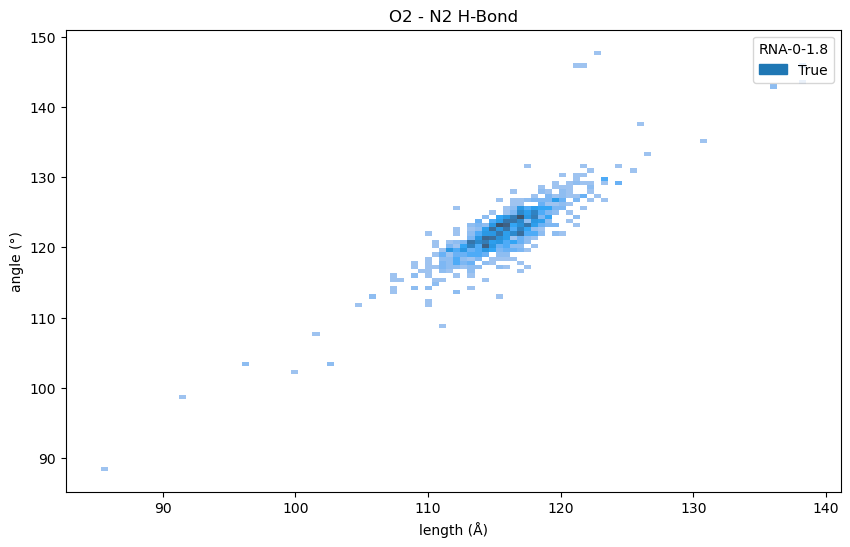

In [81]:
sns.histplot(data.filter(pl.col("DNA-0-1.8")), x="hb_1_heavy_a_angle", y="hb_2_heavy_a_angle", bins=100).set(title="O2 - N2 H-Bond", xlabel="length (Å)", ylabel="angle (°)")
show()
sns.histplot(data.filter(pl.col("RNA-0-1.8")), x="hb_1_heavy_a_angle", y="hb_2_heavy_a_angle", hue="RNA-0-1.8", bins=100).set(title="O2 - N2 H-Bond", xlabel="length (Å)", ylabel="angle (°)")
show()


In [70]:
audata = load_pair_table("/home/exyi/tmp/basepaircsv/cWW-AU-nodssr.csv.parquet")

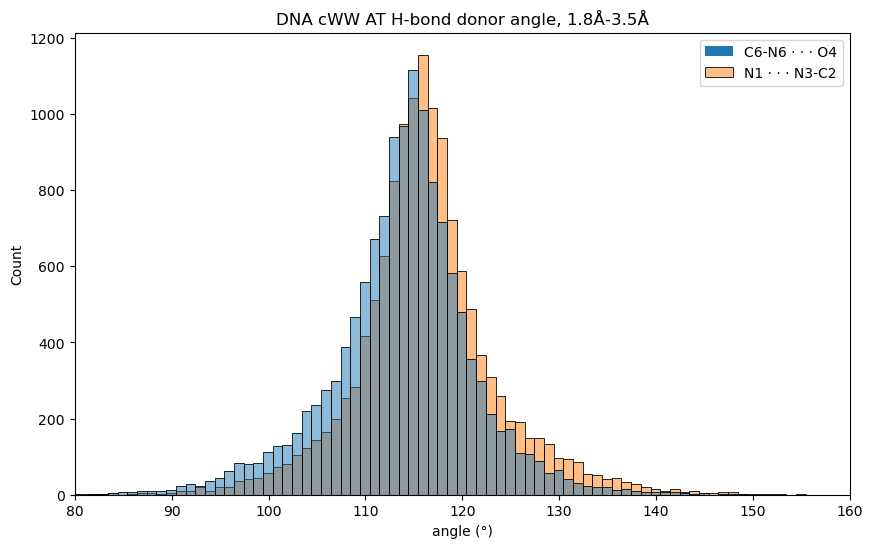

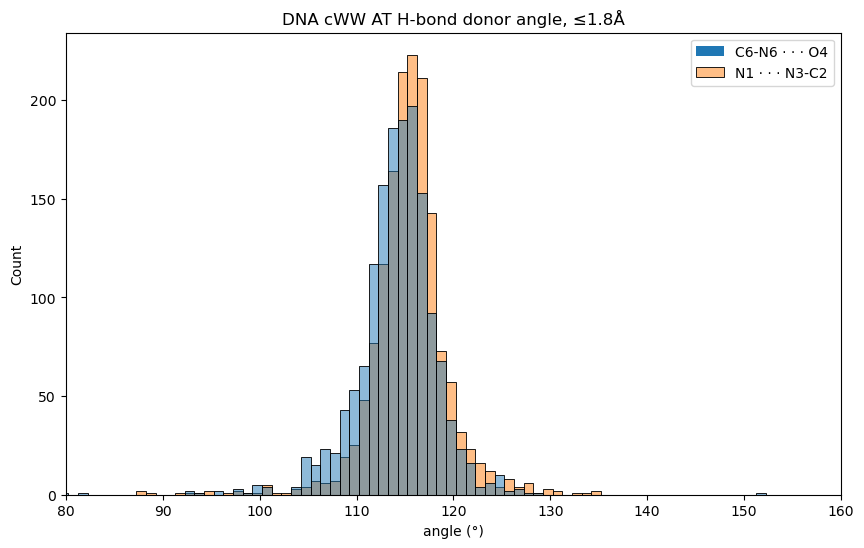

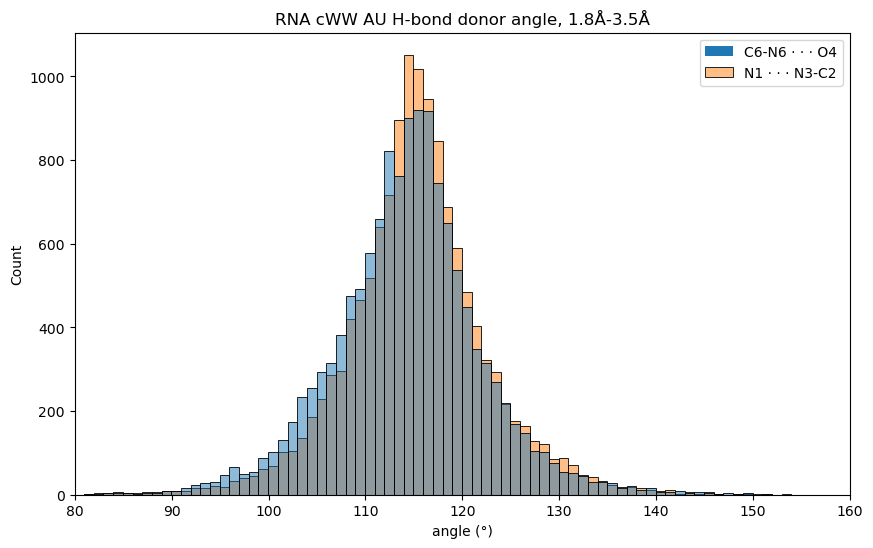

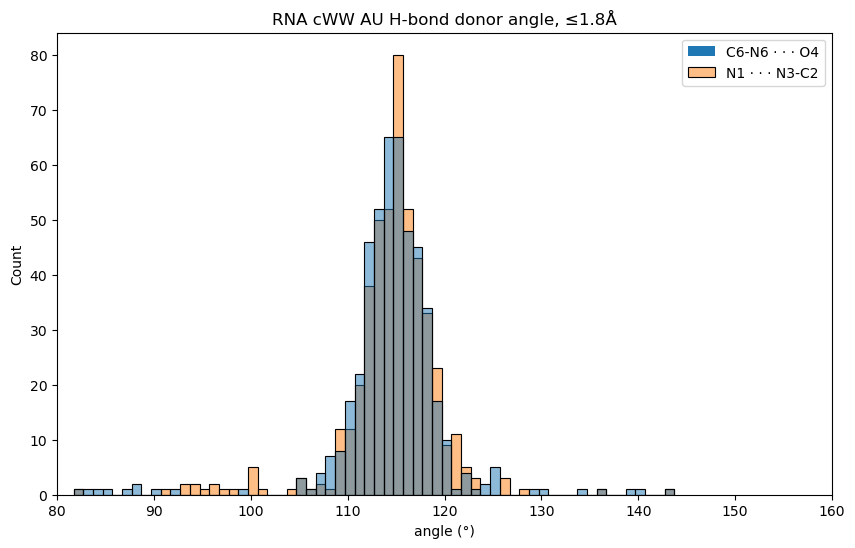

In [85]:
sns.histplot(data=audata.filter(is_med_quality & is_dna)[["hb_0_heavy_a_angle", "hb_1_heavy_a_angle"]], binwidth=1).set(xlabel="angle (°)", title="DNA cWW AT H-bond donor angle, 1.8Å-3.5Å")
plt.legend(["C6-N6 · · · O4", "N1 · · · N3-C2"])
plt.xlim(80, 160)
show()
sns.histplot(data=audata.filter(is_high_quality & is_dna)[["hb_0_heavy_a_angle", "hb_1_heavy_a_angle"]], binwidth=1).set(xlabel="angle (°)", title="DNA cWW AT H-bond donor angle, ≤1.8Å")
plt.legend(["C6-N6 · · · O4", "N1 · · · N3-C2"])
plt.xlim(80, 160)
show()
sns.histplot(data=audata.filter(is_med_quality & is_rna)[["hb_0_heavy_a_angle", "hb_1_heavy_a_angle"]], binwidth=1).set(xlabel="angle (°)", title="RNA cWW AU H-bond donor angle, 1.8Å-3.5Å")
plt.legend(["C6-N6 · · · O4", "N1 · · · N3-C2"])
plt.xlim(80, 160)
show()
sns.histplot(data=audata.filter(is_high_quality & is_rna)[["hb_0_heavy_a_angle", "hb_1_heavy_a_angle"]], binwidth=1).set(xlabel="angle (°)", title="RNA cWW AU H-bond donor angle, ≤1.8Å")
plt.legend(["C6-N6 · · · O4", "N1 · · · N3-C2"])
plt.xlim(80, 160)
show()

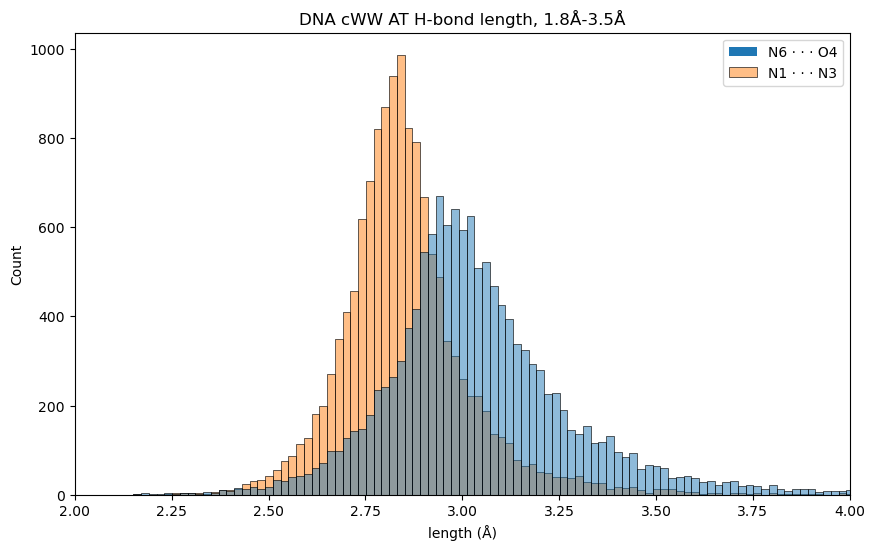

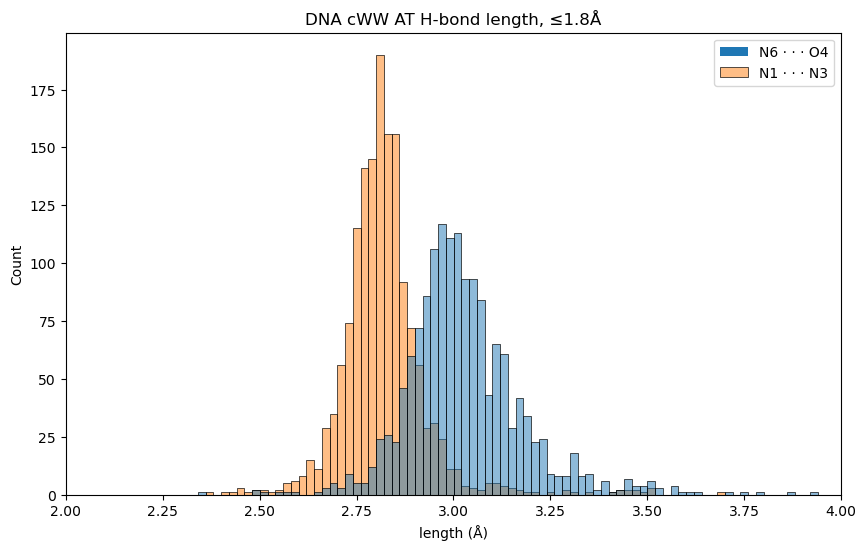

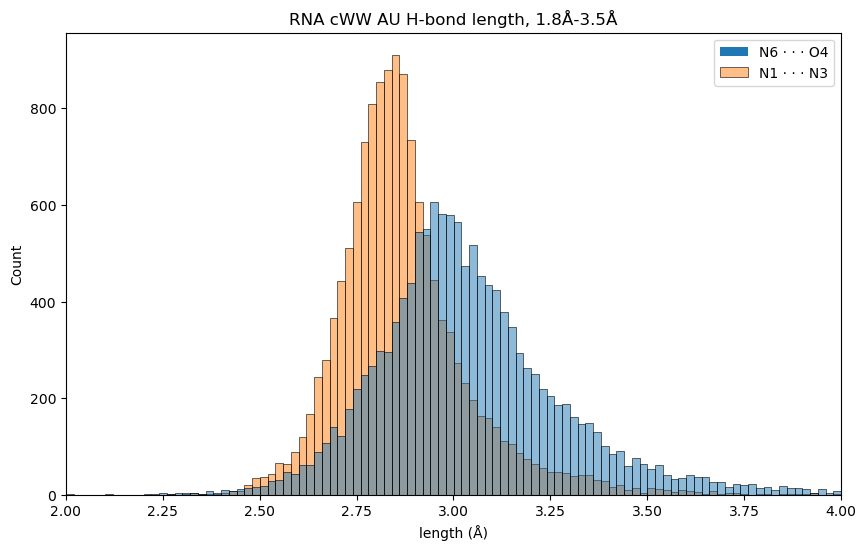

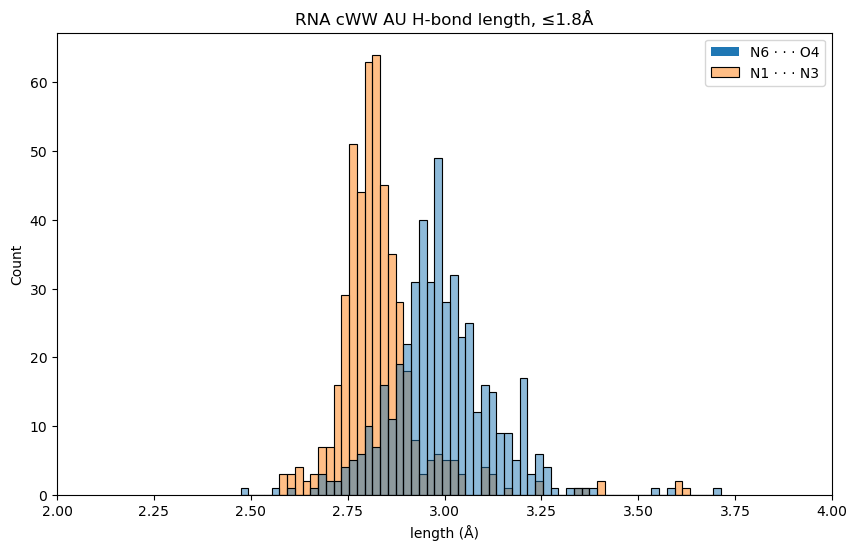

In [86]:
sns.histplot(data=audata.filter(is_med_quality & is_dna)[["hb_0_length", "hb_1_length"]], binwidth=0.02).set(xlabel="length (Å)", title="DNA cWW AT H-bond length, 1.8Å-3.5Å")
plt.legend(["N6 · · · O4", "N1 · · · N3"])
plt.xlim(2,4)
show()
sns.histplot(data=audata.filter(is_high_quality & is_dna)[["hb_0_length", "hb_1_length"]], binwidth=0.02).set(xlabel="length (Å)", title="DNA cWW AT H-bond length, ≤1.8Å")
plt.legend(["N6 · · · O4", "N1 · · · N3"])
plt.xlim(2,4)
show()
sns.histplot(data=audata.filter(is_med_quality & is_rna)[["hb_0_length", "hb_1_length"]], binwidth=0.02).set(xlabel="length (Å)", title="RNA cWW AU H-bond length, 1.8Å-3.5Å")
plt.legend(["N6 · · · O4", "N1 · · · N3"])
plt.xlim(2,4)
show()
sns.histplot(data=audata.filter(is_high_quality & is_rna)[["hb_0_length", "hb_1_length"]], binwidth=0.02).set(xlabel="length (Å)", title="RNA cWW AU H-bond length, ≤1.8Å")
plt.legend(["N6 · · · O4", "N1 · · · N3"])
plt.xlim(2,4)
show()

In [112]:
len(audata.filter(is_high_quality & is_rna))

[autoreload of fontTools.ttLib.tables.otTables failed: Traceback (most recent call last):
  File "/usr/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/usr/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/lib/python3.11/site-packages/fontTools/ttLib/tables/otTables.py", line 2266, in <module>
    _buildClasses()
  File "/usr/lib/python3.11/site-packages/fontTools/ttLib/tables/otTables.py", line 2262, in _buildClasses
    cls.converters, cls.convertersByName = buildConverters(tabl

pdbid,model,chain1,res1,nr1,ins1,atom1,alt1,chain2,res2,nr2,ins2,atom2,alt2,image,dist,rmsd,tx,ty,tz,r11,r12,r13,r21,r22,r23,r31,r32,r33,t1MMB,t2MMB,t3MMB,theta,axMMB,ayMMB,azMMB,hb_0_length,hb_0_heavy_a_angle,hb_1_length,hb_1_heavy_a_angle,hb_2_length,hb_2_heavy_a_angle,bogopropeller,deposition_date,structure_method,resolution,RNA-1.8-3.5-r1,RNA-1.8-3.5-r2,RNA-0-1.8-r1,RNA-0-1.8-r2,DNA-1.8-3.5-r1,DNA-1.8-3.5-r2,DNA-0-1.8-r1,DNA-0-1.8-r2,RNA-1.8-3.5,RNA-0-1.8,DNA-1.8-3.5,DNA-0-1.8,label
str,i64,str,str,i64,str,str,str,str,str,i64,str,str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f32,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,str
"""1csl""",1,"""A""","""A""",44,""" ""","""N6""","""?""","""B""","""U""",76,""" ""","""O4""","""?""",0,2.926,0.106,-5.816543,6.793835,1.05619,0.173097,0.881323,0.439668,0.974995,-0.216499,0.050121,0.13936,0.419998,-0.896761,-0.581654,0.679384,0.105619,3.386823,0.761754,0.618477,0.192917,2.925696,119.369536,2.954496,115.410335,null,null,null,"""1999-08-18""","""X-RAY DIFFRACT…",1.6,false,false,true,false,false,false,false,false,false,true,false,false,"""RNA H"""
"""1csl""",1,"""A""","""A""",52,""" ""","""N6""","""?""","""B""","""U""",66,""" ""","""O4""","""?""",0,2.904,0.104,-5.432511,7.304735,-0.082371,0.209079,0.964495,0.161355,0.943923,-0.242165,0.224422,0.255528,0.105385,-0.961041,-0.543251,0.730473,-0.008237,3.064932,-0.777147,-0.614821,-0.134304,2.903934,114.294897,2.960207,120.607644,null,null,null,"""1999-08-18""","""X-RAY DIFFRACT…",1.6,false,false,true,false,false,false,false,false,false,true,false,false,"""RNA H"""
"""1csl""",1,"""A""","""A""",54,""" ""","""N1""","""?""","""B""","""U""",64,""" ""","""N3""","""?""",0,2.933,0.101,-5.16079,7.403811,0.06982,0.253277,0.920062,0.298891,0.869828,-0.351809,0.345875,0.423379,0.172382,-0.889401,-0.516079,0.740381,0.006982,3.03169,-0.790891,-0.567495,-0.229,2.985981,114.568268,2.933055,117.754415,null,null,null,"""1999-08-18""","""X-RAY DIFFRACT…",1.6,false,false,true,false,false,false,false,false,false,true,false,false,"""RNA H"""
"""1dfu""",1,"""M""","""A""",94,""" ""","""N1""","""?""","""N""","""U""",82,""" ""","""N3""","""?""",0,2.841,0.106,-5.0116,7.33533,0.260274,0.329091,0.932737,0.14731,0.921313,-0.351359,0.166521,0.207079,0.080919,-0.974972,-0.50116,0.733533,0.026027,3.089055,-0.815055,-0.569082,-0.108776,3.027567,112.550514,2.840509,117.795464,null,null,null,"""1999-11-21""","""X-RAY DIFFRACT…",1.8,false,false,false,true,false,false,false,false,false,true,false,false,"""RNA H"""
"""1dqh""",1,"""A""","""A""",4,""" ""","""N1""","""?""","""B""","""U""",15,""" ""","""N3""","""?""",0,2.846,0.112,-5.373506,6.989181,0.396725,0.300616,0.94072,0.157087,0.953745,-0.296438,-0.049947,-0.000419,0.164835,-0.986321,-0.537351,0.698918,0.039672,3.275322,0.805444,0.590656,0.048846,2.971108,118.263578,2.845901,111.94805,null,null,null,"""2000-01-04""","""X-RAY DIFFRACT…",1.7,false,false,true,false,false,false,false,false,false,true,false,false,"""RNA H"""
"""1dqh""",1,"""B""","""A""",11,""" ""","""N1""","""?""","""A""","""U""",8,""" ""","""N3""","""?""",0,2.739,0.107,-4.625837,7.32872,0.251029,0.420364,0.876956,0.232899,0.87729,-0.458346,0.142414,0.231639,0.144455,-0.962017,-0.462584,0.732872,0.025103,3.140382,0.842723,0.52041,0.137809,3.065046,113.51202,2.738685,111.795778,null,null,null,"""2000-01-04""","""X-RAY DIFFRACT…",1.7,false,false,false,true,false,false,false,false,false,true,false,false,"""RNA H"""
"""1fuf""",1,"""A""","""A""",4,""" ""","""N1""","""?""","""B""","""U""",25,""" ""","""N3""","""?""",0,2.779,0.104,-4.732935,7.42642,-0.089216,0.380807,0.892693,0.24101,0.882279,-0.428797,0.194208,0.276712,0.138683,-0.950893,-0.473293,0.742642,-0.008922,3.108172,-0.830853,-0.53423,-0.155824,2.927516,117.230744,2.778686,114.18267,null,null,null,"""2000-09-15""","""X-RAY DIFFRACT…",1.7,false,false,true,false,false,false,false,false,false,true,false,false,"""R